In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

In [ ]:
# Load the dataset
data = pd.read_csv('/content/application_data.csv')

***Pre-Processing***

In [ ]:
data = data.drop_duplicates()
# Handle missing values
data = data.dropna()

 ***EDA***

In [ ]:
# Display basic statistics
print(data.describe())

          SK_ID_CURR      TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count     159.000000  159.000000    159.000000        159.000000   
mean   103316.515723    0.050314      0.559748     227264.150943   
std      1967.536218    0.219284      0.800247     128068.116410   
min    100083.000000    0.000000      0.000000      54000.000000   
25%    101505.000000    0.000000      0.000000     135000.000000   
50%    103426.000000    0.000000      0.000000     202500.000000   
75%    105071.000000    0.000000      1.000000     270000.000000   
max    106743.000000    1.000000      3.000000     810000.000000   

         AMT_CREDIT   AMT_ANNUITY  AMT_GOODS_PRICE  \
count  1.590000e+02    159.000000     1.590000e+02   
mean   7.310209e+05  32959.188679     6.733868e+05   
std    4.402862e+05  15974.557579     4.078926e+05   
min    9.000000e+04   4504.500000     9.000000e+04   
25%    3.932640e+05  22500.000000     3.622500e+05   
50%    6.750000e+05  31522.500000     6.750000e+05   
75%    1.

In [ ]:
fig = px.histogram(data, x='TARGET', color='TARGET', title='Distribution of Target Variable (Credit Default)',
                   labels={'TARGET': 'Credit Default'})
fig.show()

In [ ]:
fig = px.violin(data, x='TARGET', y='AMT_INCOME_TOTAL', box=True, points="all",
                title='Violin Plot of AMT_INCOME_TOTAL vs Target')
fig.show()


In [ ]:
fig = px.scatter_3d(data, x='AMT_INCOME_TOTAL', y='AMT_CREDIT', z='AMT_ANNUITY',
                    color='TARGET', title='3D Scatter Plot of Numerical Features')
fig.show()


In [ ]:
fig = px.histogram(data, x='DAYS_BIRTH', nbins=10,
                   title='Histogram DAYS_BIRTH')
fig.show()

In [ ]:
fig = px.sunburst(data, path=['NAME_FAMILY_STATUS'], title='Sunburst Chart of Family Status')
fig.show()

In [ ]:
fig = px.box(data, x='NAME_EDUCATION_TYPE', y='AMT_CREDIT',
              title='Box Plot of AMT_CREDIT vs Education Type')
fig.show()

***Data Prepration***

In [ ]:
# Label encode categorical variables
label_encoder = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = label_encoder.fit_transform(data[col])

In [ ]:
# Separate features and target variable
X = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = data['TARGET']

In [ ]:
# 3.3 Feature Selection
# Principal Component Analysis (PCA)
pca = PCA(n_components=20)
X = pca.fit_transform(X)

In [ ]:
smote = SMOTE()
X_OverSmote, Y_OverSmote = smote.fit_resample(X, y)

In [ ]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_OverSmote, Y_OverSmote, test_size=0.2, random_state=42)

In [ ]:
result=[]

#***Random Forest Classifier***

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_rfe, y_train_rfe)

RandomForestClassifier()

In [ ]:
y_pred = rf_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred,zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)
result.append({
        'Model': "Random forest (without tuning)",
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Feature Selection': 'PCA'
    })

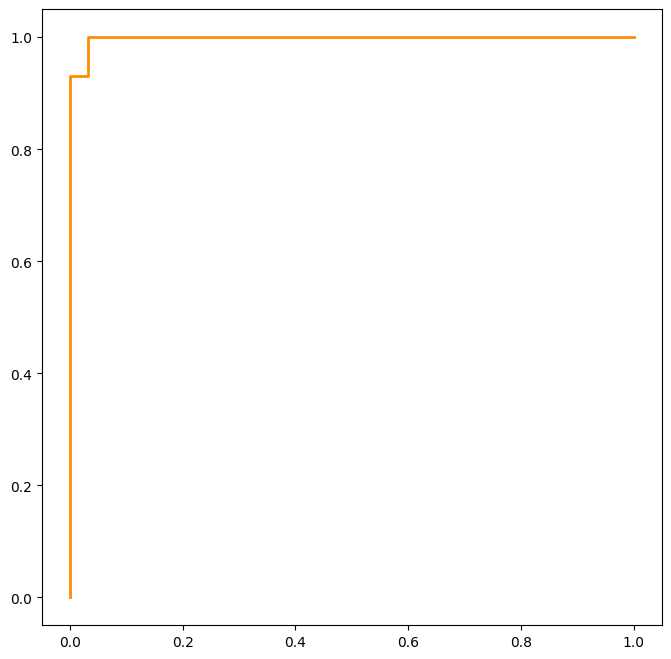

In [ ]:
# Plot ROC curve for Random Forest
rf_prob = rf_model.predict_proba(X_test_rfe)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_rfe, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

In [ ]:
  print("Classification Report:")
  print(classification_report(y_test_rfe, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       0.91      1.00      0.95        29

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.96      0.95      0.95        61



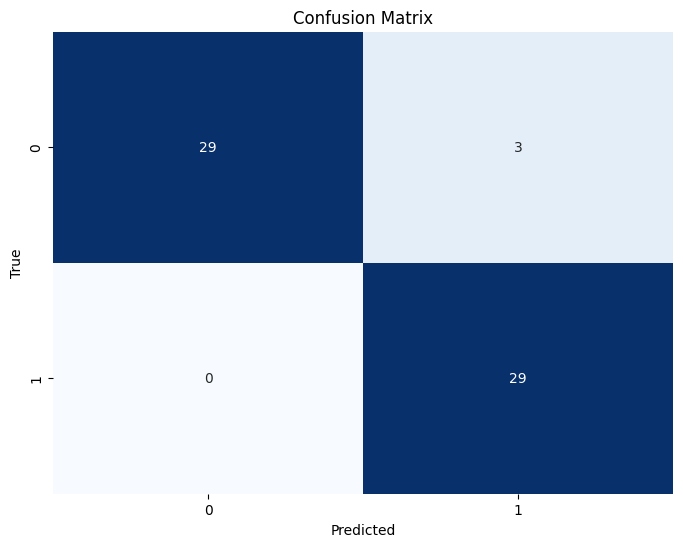

In [ ]:
conf_matrix = confusion_matrix(y_test_rfe, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

***`Tunning Random forest model`***

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
rf_model = RandomForestClassifier(random_state=32)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
# Fit the model to the training data
grid_search.fit(X_train_rfe, y_train_rfe)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=32), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100]},
             scoring='f1_macro')

In [ ]:
best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train_rfe, y_train_rfe)

RandomForestClassifier(min_samples_leaf=4, n_estimators=50, random_state=42)

In [ ]:
y_pred = best_rf_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred,zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)
result.append({
        'Model': "Random forest (tuned)",
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Feature Selection': 'PCA'
    })

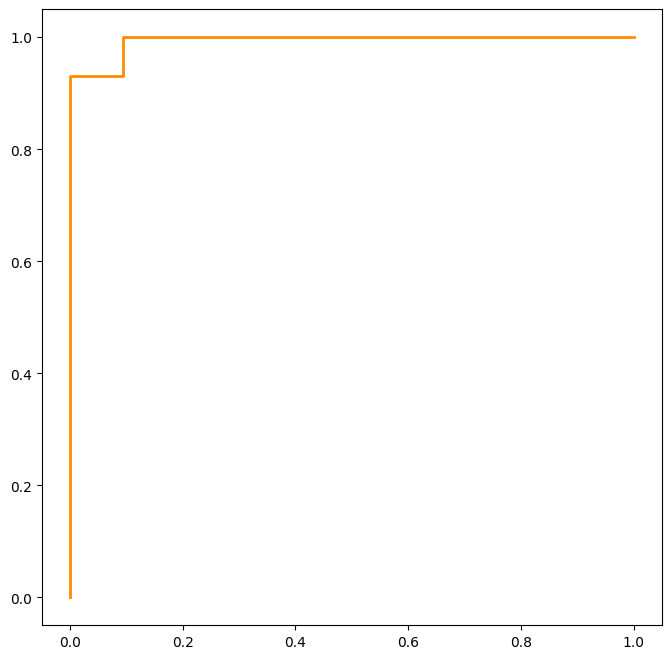

In [ ]:
# Plot ROC curve for Random Forest
rf_prob = best_rf_model.predict_proba(X_test_rfe)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_rfe, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')


In [ ]:
print("Classification Report:")
print(classification_report(y_test_rfe, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        32
           1       0.90      0.93      0.92        29

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



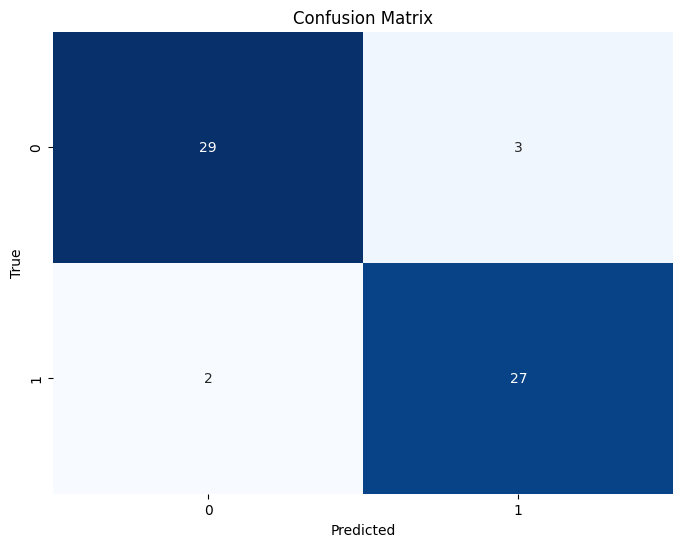

In [ ]:
conf_matrix = confusion_matrix(y_test_rfe, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***XG BOOST***

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_rfe, y_train_rfe)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred,zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)
result.append({
        'Model': "XG Boost (without tuning)",
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Feature Selection': 'PCA'
    })

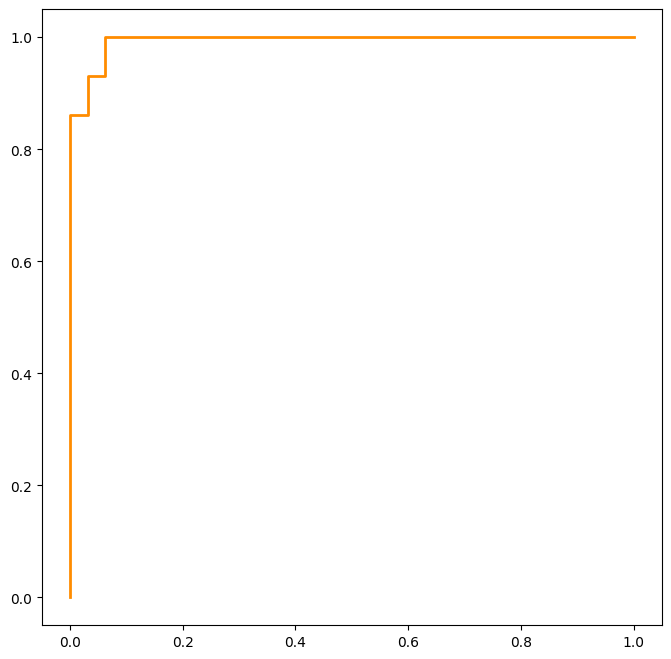

In [ ]:
# Plot ROC curve for XG Boost
rf_prob = xgb_model.predict_proba(X_test_rfe)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_rfe, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

In [ ]:
print("Classification Report:")
print(classification_report(y_test_rfe, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.94      1.00      0.97        29

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



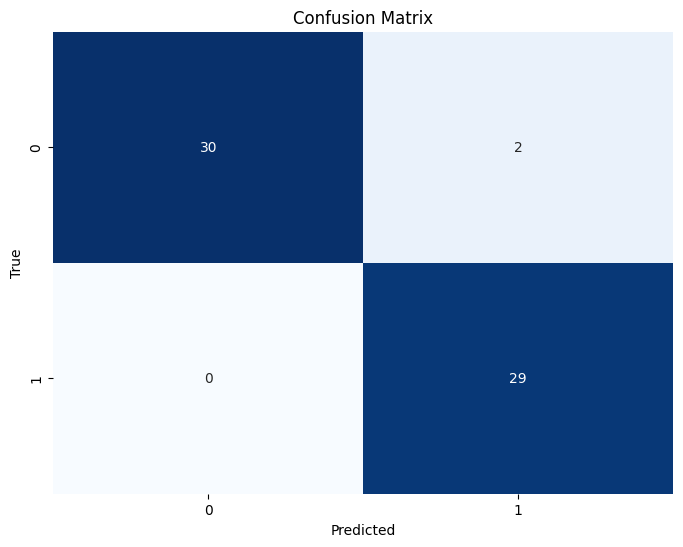

In [ ]:
conf_matrix = confusion_matrix(y_test_rfe, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

***XG Boost Tuning***

In [ ]:
# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_rfe, y_train_rfe)
best_params = grid_search.best_params_

In [ ]:
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', **best_params, random_state=42)
best_xgb_model.fit(X_train_rfe, y_train_rfe)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = best_xgb_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred,zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)
result.append({
        'Model': "XG Boost (tuning)",
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Feature Selection': 'PCA'
    })

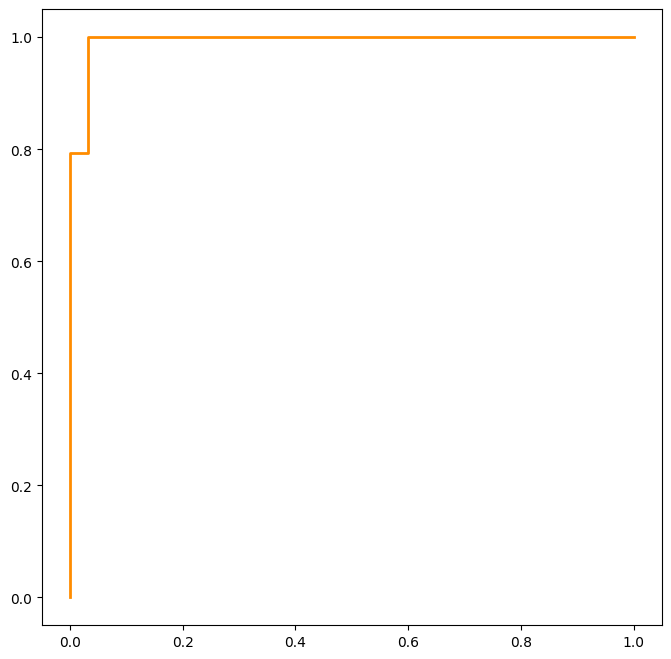

In [ ]:
# Plot ROC curve for XG Boost
rf_prob = best_xgb_model.predict_proba(X_test_rfe)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_rfe, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

In [ ]:
print("Classification Report:")
print(classification_report(y_test_rfe, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.94      1.00      0.97        29

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61



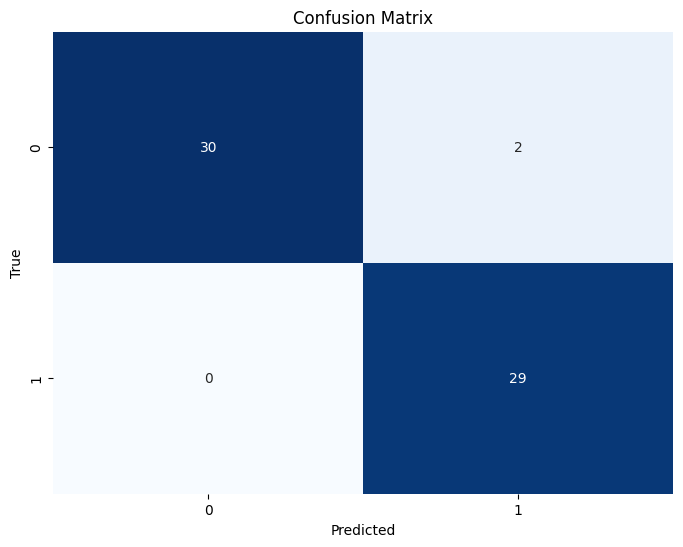

In [ ]:
conf_matrix = confusion_matrix(y_test_rfe, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***Ada Boost***

In [ ]:
#Train the AdaBoost model
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_rfe, y_train_rfe)

AdaBoostClassifier()

In [ ]:
# Evaluate the model
y_pred = adaboost_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred, zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)

In [ ]:
# Add results to the result list
result.append({
    'Model': "AdaBoost",
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Feature Selection': 'PCA'
})

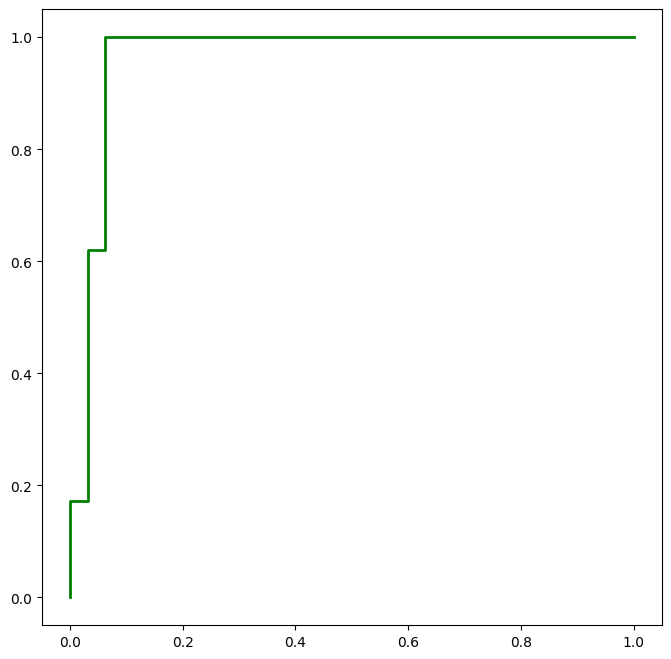

In [ ]:
# Plot ROC curve for AdaBoost
adaboost_prob = adaboost_model.predict_proba(X_test_rfe)[:, 1]
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test_rfe, adaboost_prob)
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)
plt.figure(figsize=(8, 8))
plt.plot(fpr_adaboost, tpr_adaboost, color='green', lw=2, label=f'AdaBoost (AUC = {roc_auc_adaboost:.2f})')

Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        32
           1       0.88      1.00      0.94        29

    accuracy                           0.93        61
   macro avg       0.94      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61



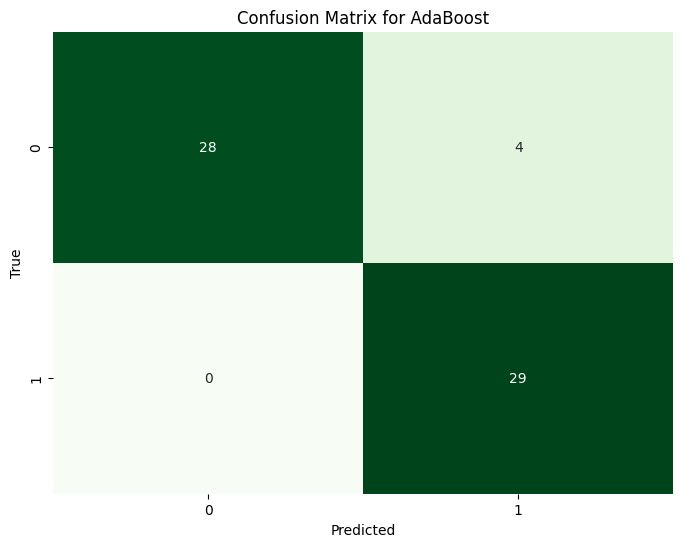

In [ ]:
# Display classification report and confusion matrix
print("Classification Report for AdaBoost:")
print(classification_report(y_test_rfe, y_pred))
conf_matrix_adaboost = confusion_matrix(y_test_rfe, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adaboost, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix for AdaBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***Tuned Ada Boost***

In [ ]:
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Create AdaBoost model
adaboost_model = AdaBoostClassifier()

# GridSearchCV for hyperparameter tuning
grid_search_adaboost = GridSearchCV(adaboost_model, param_grid_adaboost, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search_adaboost.fit(X_train_rfe, y_train_rfe)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_macro')

In [ ]:
# Get best parameters and retrain the model
best_params_adaboost = grid_search_adaboost.best_params_
best_adaboost_model = AdaBoostClassifier(**best_params_adaboost)
best_adaboost_model.fit(X_train_rfe, y_train_rfe)

AdaBoostClassifier(learning_rate=1, n_estimators=100)

In [ ]:
# Evaluate the model
y_pred = best_adaboost_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred, zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)

In [ ]:
# Add results to the result list
result.append({
    'Model': "Tuned AdaBoost",
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Feature Selection': 'PCA'
})


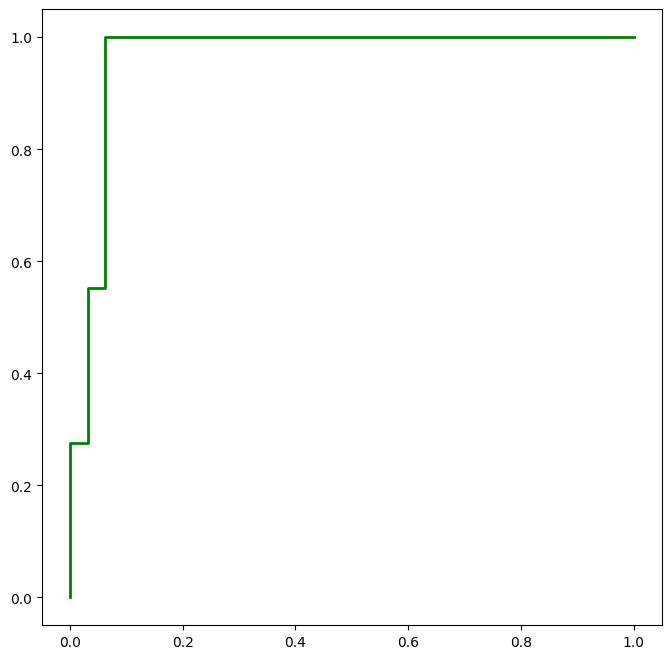

In [ ]:
# Plot ROC curve for AdaBoost
adaboost_prob = best_adaboost_model.predict_proba(X_test_rfe)[:, 1]
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test_rfe, adaboost_prob)
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)
plt.figure(figsize=(8, 8))
plt.plot(fpr_adaboost, tpr_adaboost, color='green', lw=2, label=f'AdaBoost (AUC = {roc_auc_adaboost:.2f})')


Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       0.91      1.00      0.95        29

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.96      0.95      0.95        61



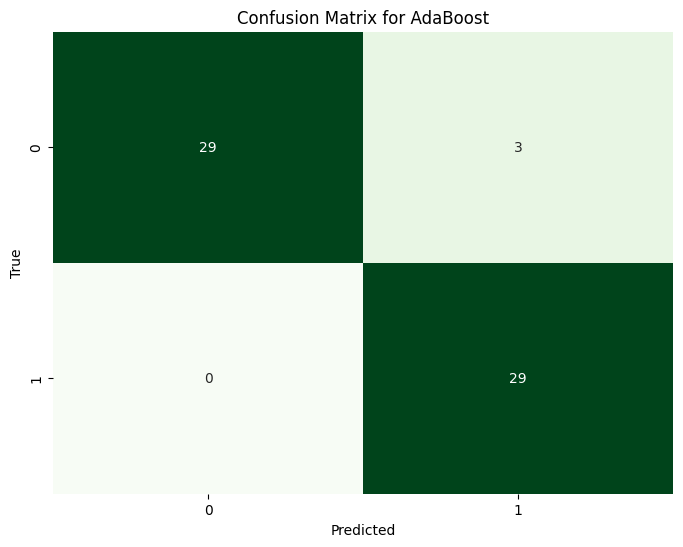

In [ ]:
# Display classification report and confusion matrix
print("Classification Report for AdaBoost:")
print(classification_report(y_test_rfe, y_pred))
conf_matrix_adaboost = confusion_matrix(y_test_rfe, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adaboost, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix for AdaBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***Gradient Boosting***





In [ ]:
gradient_boost_model = GradientBoostingClassifier()
gradient_boost_model.fit(X_train_rfe, y_train_rfe)

GradientBoostingClassifier()

In [ ]:
# Evaluate the model
y_pred = gradient_boost_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred, zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)

In [ ]:
# Add results to the result list
result.append({
    'Model': "Gradient Boosting",
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Feature Selection': 'PCA'
})

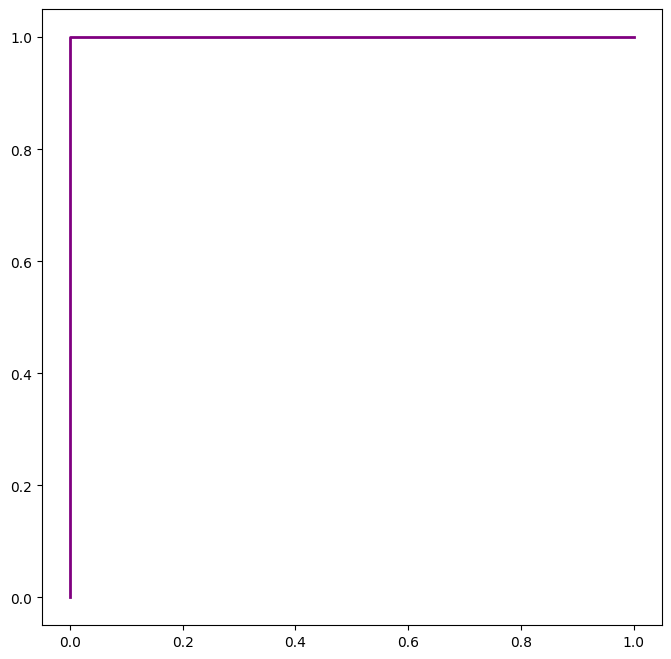

In [ ]:
# Plot ROC curve for Gradient Boost
svm_prob = gradient_boost_model.predict_proba(X_test_rfe)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_rfe, svm_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'Gradient Boost (AUC = {roc_auc_svm:.2f})')


Classification Report for gradient boost:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       0.91      1.00      0.95        29

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.96      0.95      0.95        61



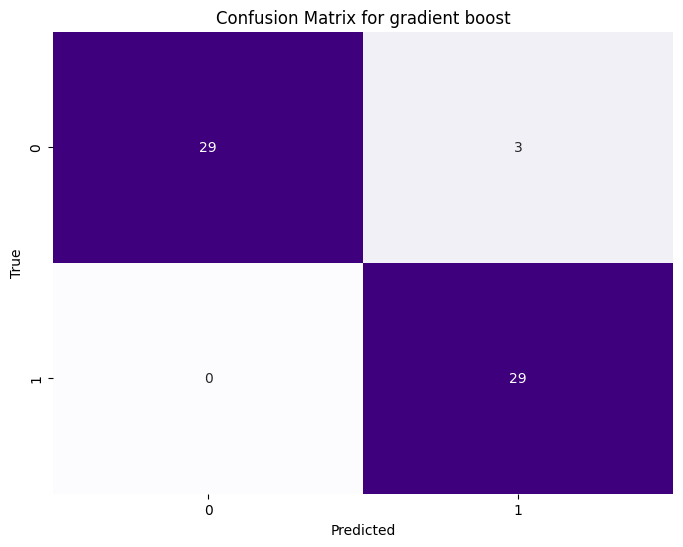

In [ ]:
# Display classification report and confusion matrix
print("Classification Report for gradient boost:")
print(classification_report(y_test_rfe, y_pred))
conf_matrix_svm = confusion_matrix(y_test_rfe, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix for gradient boost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***Tuned Gradient Boost***

In [ ]:
# Define the parameter grid for Gradient Boosting
param_grid_gradient_boost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
# Create Gradient Boosting model
gradient_boost_model = GradientBoostingClassifier()

# GridSearchCV for hyperparameter tuning
grid_search_gradient_boost = GridSearchCV(gradient_boost_model, param_grid_gradient_boost, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search_gradient_boost.fit(X_train_rfe, y_train_rfe)

# Get best parameters and retrain the model
best_params_gradient_boost = grid_search_gradient_boost.best_params_
best_gradient_boost_model = GradientBoostingClassifier(**best_params_gradient_boost)
best_gradient_boost_model.fit(X_train_rfe, y_train_rfe)

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, min_samples_leaf=4,
                           min_samples_split=10, n_estimators=50)

In [ ]:
# Evaluate the model
y_pred = best_gradient_boost_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred, zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)

# Add results to the result list
result.append({
    'Model': "Tuned gradient boost",
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Feature Selection': 'PCA'
})


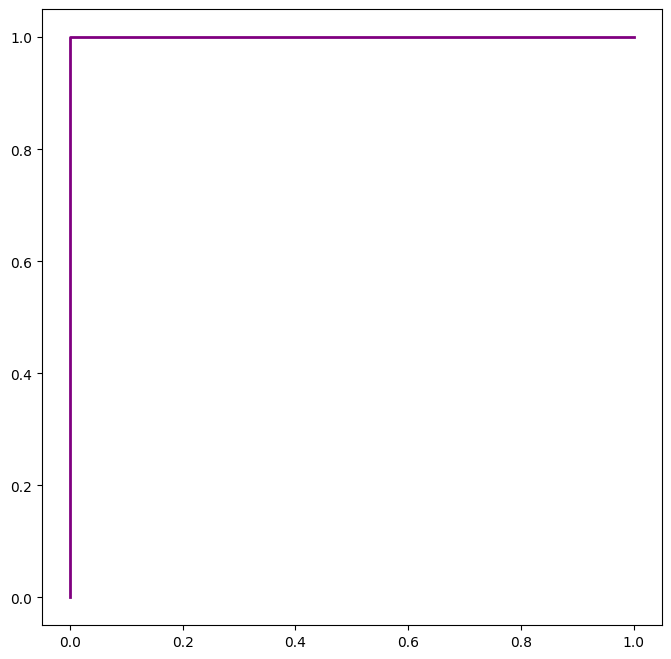

In [ ]:
# Plot ROC curve for Gradient Boost
svm_prob = best_gradient_boost_model.predict_proba(X_test_rfe)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_rfe, svm_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'Gradient Boost (AUC = {roc_auc_svm:.2f})')


Classification Report for Gradient Boost:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        32
           1       0.88      1.00      0.94        29

    accuracy                           0.93        61
   macro avg       0.94      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61



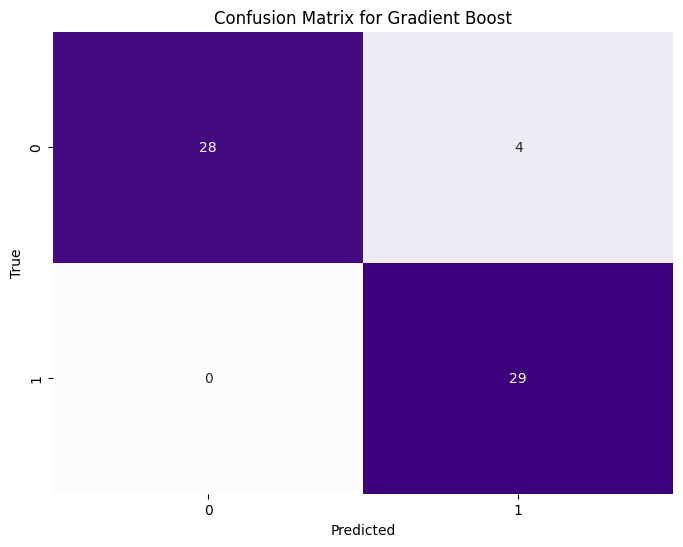

In [ ]:
# Display classification report and confusion matrix
print("Classification Report for Gradient Boost:")
print(classification_report(y_test_rfe, y_pred))
conf_matrix_svm = confusion_matrix(y_test_rfe, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix for Gradient Boost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***Neural Network (MLP)***

In [ ]:
# Create and train the Neural Network model
mlp_model = MLPClassifier()
mlp_model.fit(X_train_rfe, y_train_rfe)

MLPClassifier()

In [ ]:
# Evaluate the model
y_pred = mlp_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred, zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)

# Add results to the result list
result.append({
    'Model': "Neural Network",
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Feature Selection': 'PCA'
})


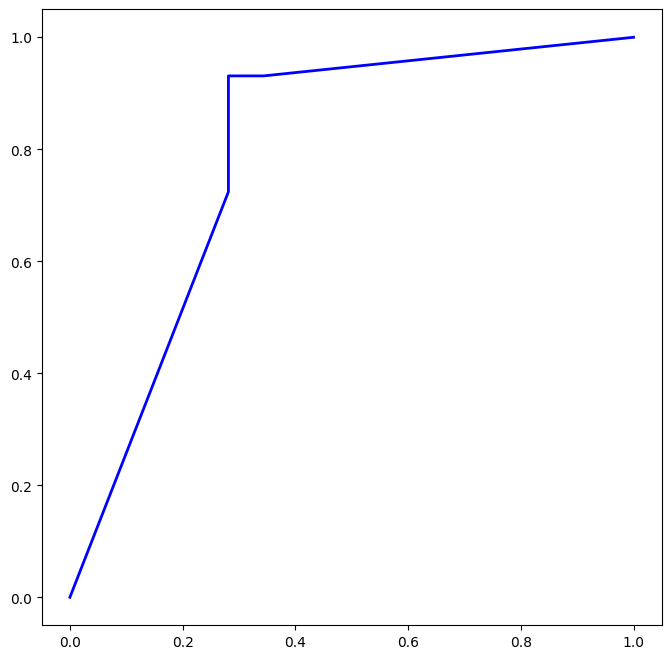

In [ ]:
# Plot ROC curve for Neural Network
mlp_prob = mlp_model.predict_proba(X_test_rfe)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_rfe, mlp_prob)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(figsize=(8, 8))
plt.plot(fpr_mlp, tpr_mlp, color='blue', lw=2, label=f'Neural Network (AUC = {roc_auc_mlp:.2f})')


Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        32
           1       0.70      0.72      0.71        29

    accuracy                           0.72        61
   macro avg       0.72      0.72      0.72        61
weighted avg       0.72      0.72      0.72        61



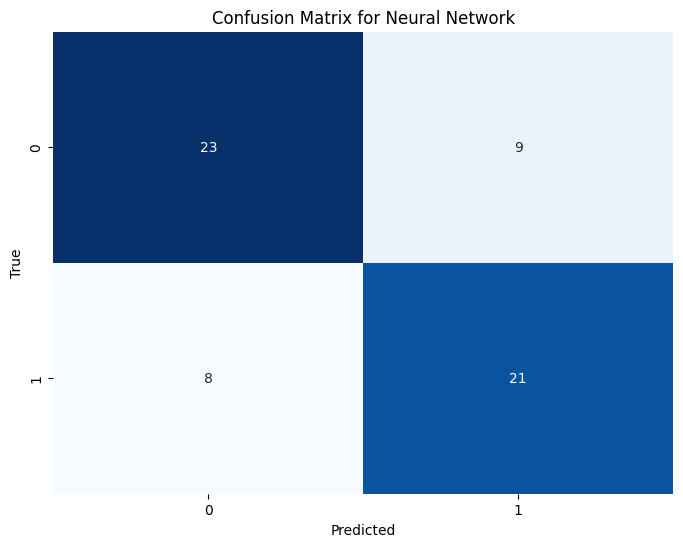

In [ ]:
# Display classification report and confusion matrix
print("Classification Report for Neural Network:")
print(classification_report(y_test_rfe, y_pred))
conf_matrix_mlp = confusion_matrix(y_test_rfe, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***Tuned Neural Network***

In [ ]:
aram_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200]
}

# Create MLP model
mlp_model = MLPClassifier()

# GridSearchCV for hyperparameter tuning
grid_search_mlp = GridSearchCV(mlp_model, aram_grid_mlp, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search_mlp.fit(X_train_rfe, y_train_rfe)

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50, 50), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200]},
             scoring='f1_macro')

In [ ]:
# Get best parameters and retrain the model
best_params_mlp = grid_search_mlp.best_params_
best_mlp_model = MLPClassifier(**best_params_mlp)
best_mlp_model.fit(X_train_rfe, y_train_rfe)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=100)

In [ ]:
  # Evaluate the model
y_pred = best_mlp_model.predict(X_test_rfe)
accuracy = accuracy_score(y_test_rfe, y_pred)
precision = precision_score(y_test_rfe, y_pred, zero_division=1)
recall = recall_score(y_test_rfe, y_pred)
f1 = f1_score(y_test_rfe, y_pred)

# Add results to the result list
result.append({
    'Model': "Tuned Neural Network",
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Feature Selection': 'PCA'
})

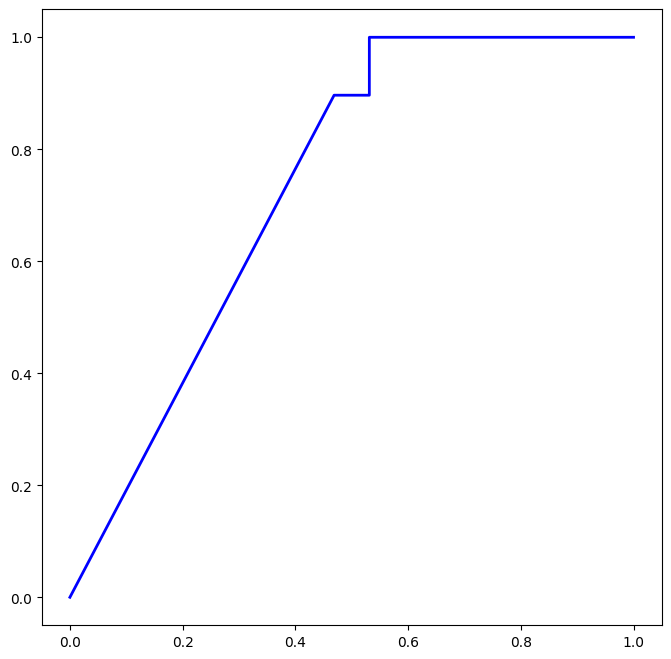

In [ ]:
# Plot ROC curve for Neural Network
mlp_prob = best_mlp_model.predict_proba(X_test_rfe)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test_rfe, mlp_prob)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
plt.figure(figsize=(8, 8))
plt.plot(fpr_mlp, tpr_mlp, color='blue', lw=2, label=f'Neural Network (AUC = {roc_auc_mlp:.2f})')


Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.85      0.53      0.65        32
           1       0.63      0.90      0.74        29

    accuracy                           0.70        61
   macro avg       0.74      0.71      0.70        61
weighted avg       0.75      0.70      0.70        61



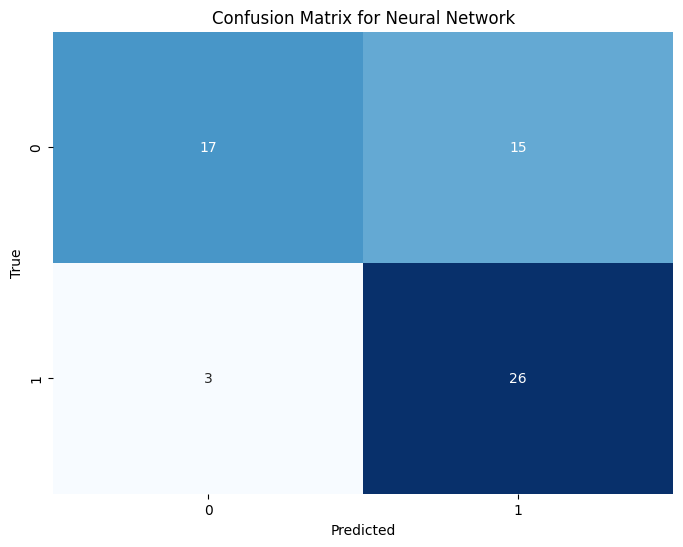

In [ ]:
# Display classification report and confusion matrix
print("Classification Report for Neural Network:")
print(classification_report(y_test_rfe, y_pred))
conf_matrix_mlp = confusion_matrix(y_test_rfe, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#***Compare Models before Tuning and after Tuning***

In [ ]:
name=[]
accuracy=[]
for i in result:
  name.append(i['Model'])
  accuracy.append(round(i['Accuracy'],3))
df = pd.DataFrame({'Model': name, 'Accuracy': accuracy})
fig = px.bar(df, x='Model', y='Accuracy', text='Accuracy',
             labels={'Accuracy': 'Accuracy Score'},
             title='Model Accuracies',
             height=400)

# Customize layout if needed
fig.update_layout(
    xaxis_title='Model',
    yaxis_title='Accuracy Score',
    yaxis=dict(tickformat='%'),
    bargap=0.1  # Adjust the gap between bars
)

# Show the figure
fig.show()


#***Feacture selection for random Forest***

In [ ]:
original_columns = data.drop(['TARGET', 'SK_ID_CURR'], axis=1).columns
rf_feature_selection = RandomForestClassifier(random_state=42)
rf_feature_selection.fit(X_train_rfe, y_train_rfe)
feature_importances = rf_feature_selection.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = original_columns[sorted_idx][:10]
print("Top 10 Important Features:")
print(top_features)

Top 10 Important Features:
Index(['NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
       'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'DAYS_EMPLOYED', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'NAME_CONTRACT_TYPE'],
      dtype='object')


In [ ]:
# Select the top 30 important features
selected_features = original_columns[sorted_idx][:30]
X_train_top = pd.DataFrame(X_train_rfe, columns=selected_features)
X_test_top = pd.DataFrame(X_test_rfe, columns=selected_features)

rf_top_model = RandomForestClassifier(random_state=32)
rf_top_model.fit(X_train_top, y_train_rfe)
# Predictions on training set
train_preds = rf_top_model.predict(X_train_rfe)
train_auc = roc_auc_score(y_train_rfe, train_preds)

# Predictions on test set
test_preds = rf_top_model.predict(X_test_top)
test_auc = roc_auc_score(y_test_rfe, test_preds)

print(f"Train AUC with Top Features: {train_auc:.4f}")
print(f"Test AUC with Top Features: {test_auc:.4f}")

Train AUC with Top Features: 1.0000
Test AUC with Top Features: 0.9531


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

